# Stochastic analysis of time series

algorithm by "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Drift and Diffusion coefficients

They are defined in \[1\](4) as

$$
D^{(1)}_{i} = \lim_{\tau \to 0} \frac{1}{\tau} < X_i(t + \tau) - x_i >_{X(t) = \vec{x}}
\\
D^{(2)}_{ij} = \lim_{\tau \to 0} \frac{1}{\tau} < (X_i(t + \tau) - x_i)(X_j(t + \tau) - x_j) >_{X(t) = \vec{x}}
$$

In case of HO they write:
$$
D^{(1)}_{x} = \lim_{\tau \to 0} \frac{1}{\tau} < x(t + \tau) - x(t) >
\\
D^{(1)}_{v} = \lim_{\tau \to 0} \frac{1}{\tau} < v(t + \tau) - v(t) >
$$

As there are no limes-funcitons implemented, we will use the value of $D^{(i)}$ where $\tau$ equals the smallest possible value. Thus $\tau$ needs to be a integer value greater than 0, $\tau$ will be assumed as 1: $\lim_{\tau \to 0} \tau = 1$

In [2]:
def D_1(s, i, x, tau=1, fw=1, bins=25):
    '''Retrieving Drift-Coefficient
    
    Parameters:
        - (array like)[2] s: (Array of arrays of float) time series.
            multiple dimensions possible
        - (int) i: index of dimension, which time series s[i] shall be examined.
        - (array like)[2] x: (Array of array of float) initial values at time t.
        - (int) tau: timestep
        - (int) tau: forward time step: derivate evaluation
        - (float) bins: defines the threshold
        
    Usage:
        >>> D_1([x, v], 0, [ax, 0], tau=1, bins=25)
        >>> [D_1([x, v], 0, [ax, 0], tau=1, bins=10) for ax in arx]
        >>> D_1([x, v], 1, [0, ax], tau=1, bins=25)
    '''    
    s[i] = np.array(s[i])
    
    # times where the series equals IVP
    indices = np.where(abs(s[i][:-fw] - x[i]) <= (1 / bins))    

    result = (1 / tau) * np.mean([s[i][t + fw] - s[i][t] for t in indices])
    
    return result

# ToDo:
# - Handling empty slices of np.where()

In [3]:
def D_2(s, i, j, x, tau=1, fw=1, bins=25):
    '''Retrieving Diffusion-Coefficient
    '''
    s[i] = np.array(s[i])
    s[j] = np.array(s[j])
    
    # times where the series equals IVP
    indices_i = np.where(abs(s[i][:-fw] - x[i]) <= (1 / bins))
    indices_j = np.where(abs(s[j][:-fw] - x[j]) <= (1 / bins))
    
    indices = np.intersect1d(indices_i, indices_j)
    
    result = (1 / tau) * np.mean([(s[i][t + fw] - x[i]) *
                                  (s[j][t + fw] - x[j]) for t in indices])
    
    return result

## 2. Applying on time series

We will use different time series. For one example we will use the harmonic oscillator (HO). The HO is defined as follows:

$$
\dot{x} = v\\
\dot{v} = -f'(x) + \Gamma(t) - \gamma v
$$

Furthermore we will use a Langevin-Equation to create somewhat a telegram-signal:

$$
\dot{X}(t) = \varepsilon X(t) - X^{3}(t) - \gamma \Gamma (t)\\
\varepsilon = 0.1 \text{ and } \gamma = 0.05
$$

Where Gamma represents a gaussian white noise. The time series can be derived by integration. This will be done in the following.

### 2.1 Harmonic Oscillator

#### 2.1.1 Creating time series

In [723]:
dt = 0.001
T = 20 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0
epsilon = 0.01

x = []
v = []
x = np.zeros(n)
v = np.zeros(n)
x[0] = 1
v[0] = 0

f = lambda x: x

for i in range(n - 1):
    x[i + 1] = x[i] + dt * v[i]
    v[i + 1] = v[i] - dt * (f(x[i + 1]) + gamma * v[i]) + sqrtdt * np.random.randn() * epsilon
    # using x[i + 1] instead of x[i] for closed loop

<IPython.core.display.Javascript object>


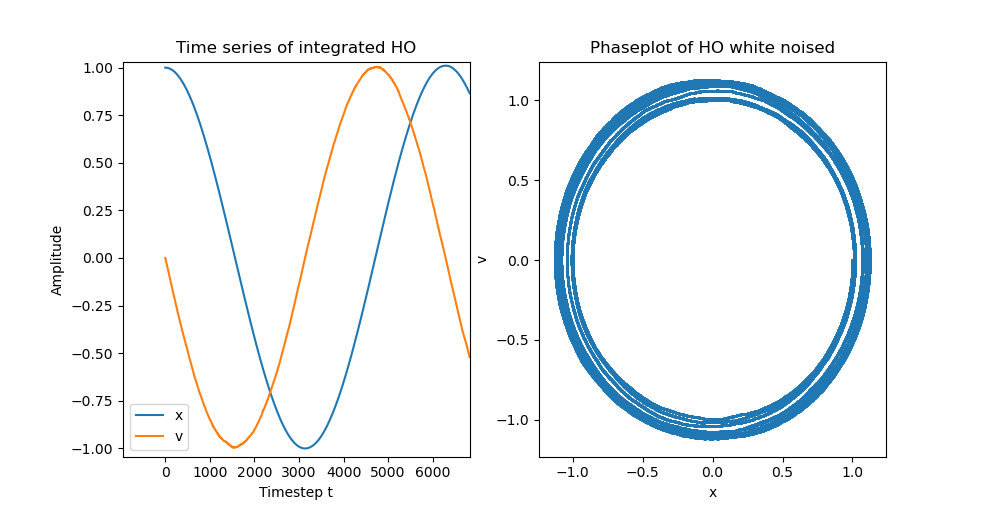

In [724]:
%matplotlib notebook

plt.subplot(121)
plt.plot(x, label='x')
plt.plot(v, label='v')
plt.title('Time series of integrated HO')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.scatter(x, v, s=1, label='phaseplot')
plt.title('Phaseplot of HO white noised')
plt.xlabel('x')
plt.ylabel('v')

plt.show()

#### 2.1.2 Retrieving Drift and Diffusion coefficients

In [800]:
# hardcoding 2D diffusion coefficient for HO

nx, ny = (250, 250)
xd = np.zeros(nx)
yd = np.zeros(ny)

xv, yv = np.meshgrid(xd, yd)

x_bins = xv # using bins, copying xv-grid
y_bins = xv

In [801]:
# Abtasten der Zeitserie
dx = np.max(x) - np.min(x) # "offset" x
dy = np.max(v) - np.min(v) # "offset" y

tau = 1

transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1

for i in range(len(x[:-tau])):
    # 1. Transform x and y values of phase plot to meshgrid size
    xc = transform(x[i], dx, nx)
    yc = transform(v[i], dy, ny)
    # 2. First calculate mean x change,then mean y change
    if (x_bins[xc][yc] == 0):
        x_bins[xc][yc] = x[i + tau] - x[i]
        y_bins[xc][yc] = v[i + tau] - v[i]
    else:
        x_bins[xc][yc] = np.mean([x_bins[xc][yc], x[i + tau] - x[i]]) # calculate mean change
        y_bins[xc][yc] = np.mean([y_bins[xc][yc], v[i + tau] - v[i]])

<IPython.core.display.Javascript object>


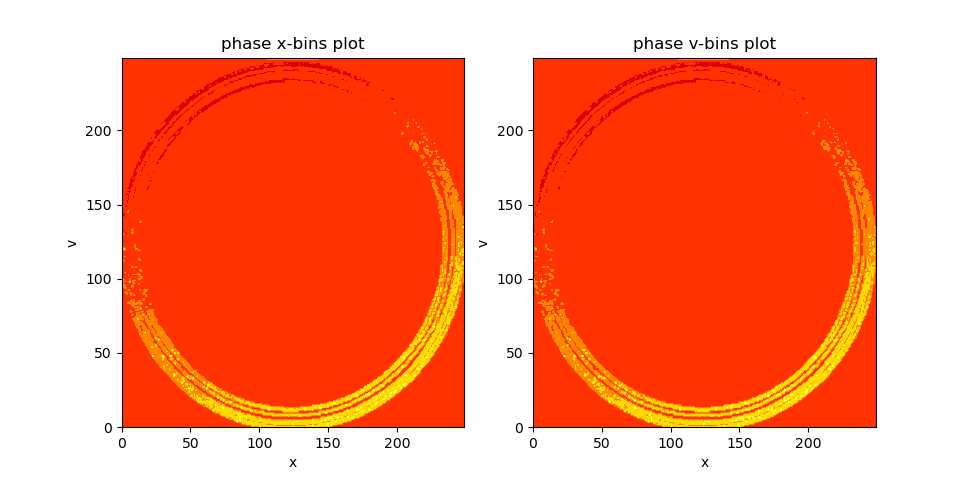

<IPython.core.display.Javascript object>


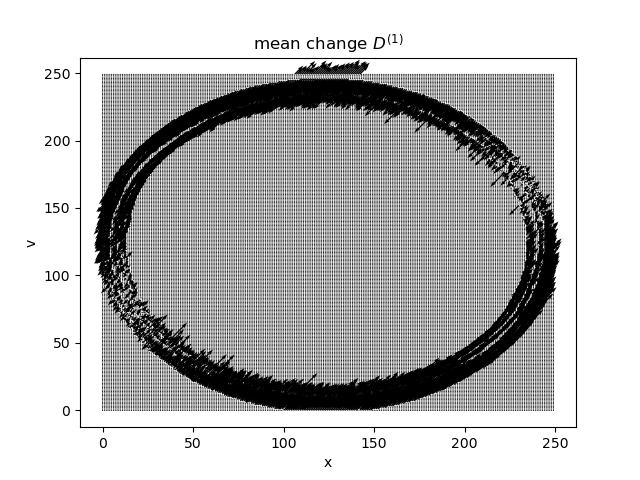

<IPython.core.display.Javascript object>


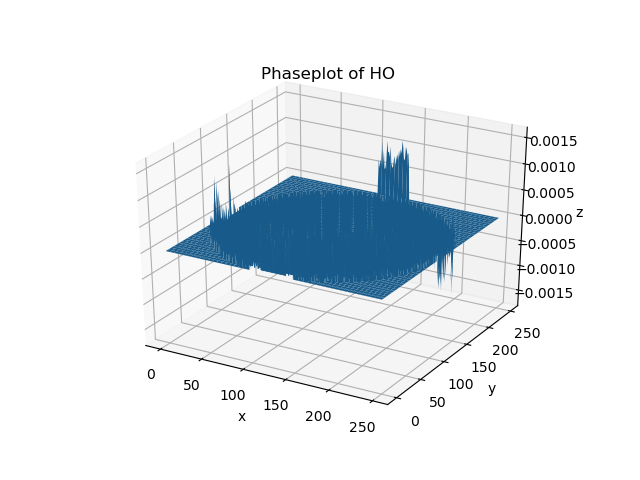

In [802]:
%matplotlib notebook

# standard axis
xd = np.arange(0, nx)
yd = np.arange(0, ny)
xv, yv = np.meshgrid(xd, yd)

# contour
plt.subplot(121)
plt.title('phase x-bins plot')
cs = plt.contourf(x_bins, cmap='hot')
plt.xlabel('x')
plt.ylabel('v')
#plt.colorbar(cs)

plt.subplot(122)
plt.title('phase v-bins plot')
cs = plt.contourf(y_bins, cmap='hot')
plt.xlabel('x')
plt.ylabel('v')
#plt.colorbar(cs)

# vector field
fig, ax = plt.subplots()
plt.title('mean change $D^{(1)}$')
#ax.quiver(xd, yd, np.gradient(bins)[0], np.gradient(bins)[1])
ax.quiver(xd, yd, x_bins, y_bins)
plt.xlabel('x')
plt.ylabel('v')
plt.show()

# 3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv, x_bins, lw=0.5, label='bins')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Phaseplot of HO")
plt.show()

#### 2.1.3 Reconstructing time series

In [ ]:
dt = 0.001
T = 2 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

x_ = []
v_ = []
x_ = np.zeros(n)
v_ = np.zeros(n)
x_[0] = 0.75
v_[0] = -0.5

for i in range(n - 1):
    x_[i + 1] = x_[i]
    v_[i + 1] = v_[i]
    # 1. Deterministic dynamics
    x_[i + 1] += D_1([x], 0, [x_[i]], tau=dt, bins=50) * dt
    v_[i + 1] += D_1([v], 0, [v_[i]], tau=dt, bins=50) * dt
    # 2. Stochastic dynamics
    # ToDo: Implement noise amplitudes g_ij() [?] and random gamma. [1](12)
    #x_[i + 1] += sqrtdt * np.random.randn() * epsilon
    #v_[i + 1] += sqrtdt * np.random.randn() * epsilon

In [ ]:
%matplotlib notebook
plt.plot(x_, label='x')
plt.plot(v_, label='v')

plt.title('Reconstructed HO\nw/o stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')
plt.legend()

plt.show()

### 2.2 Langevin telegram signal

#### 2.2.1 Creating time series

In [650]:
dt = 0.001
T = 1000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05
epsilon = 0.1

langevin =[]
langevin = np.zeros(n)

for i in range(n - 1):
    langevin[i + 1] = langevin[i] + dt * (epsilon * langevin[i] - langevin[i] ** 3) +\
                      sqrtdt * gamma * np.random.randn()

<IPython.core.display.Javascript object>


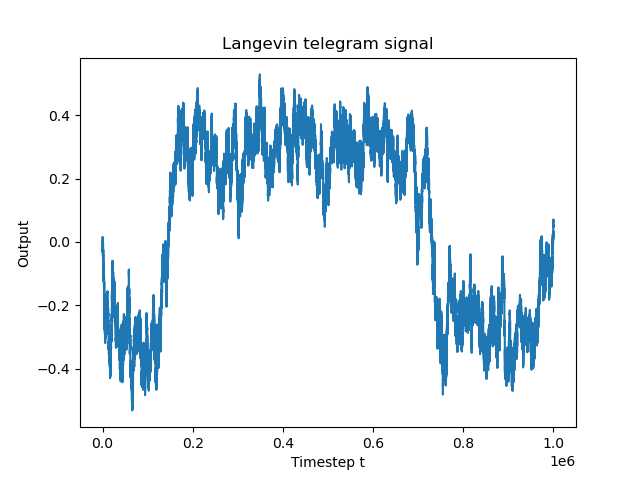

In [651]:
%matplotlib notebook
plt.plot(langevin, label='Langevin')

plt.title('Langevin telegram signal')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

#### 2.2.2 Retrieving Drift and Diffusion coefficients

In [652]:
arl = np.linspace(np.min(langevin), np.max(langevin), 250)
# D_1
l_output = [D_1([langevin], 0, [al], tau=dt, bins=15) for al in arl]

In [653]:
# D_2
ll_output = [D_2([langevin], 0, 0, [al], tau=dt, bins=15) for al in arl]

<IPython.core.display.Javascript object>


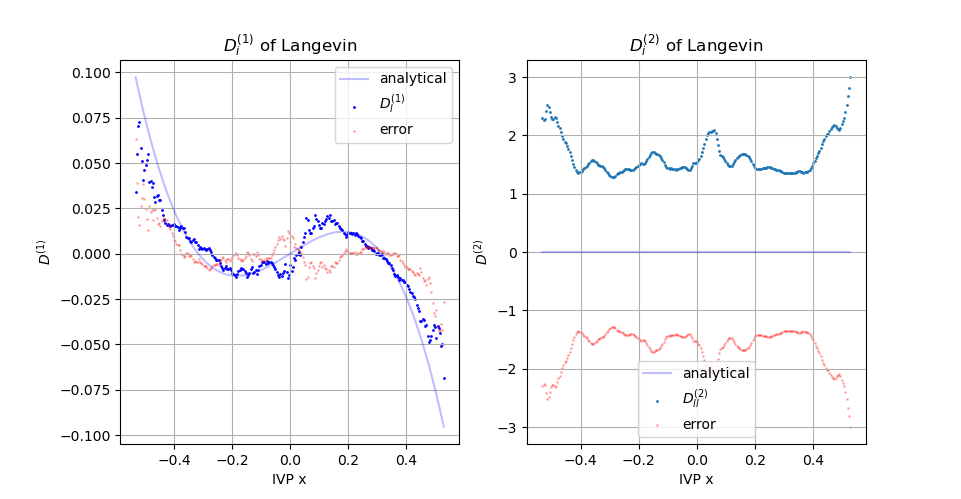

In [654]:
%matplotlib notebook
# Plot D_1 ----------
plt.subplot(121)
plt.scatter(arl, l_output, s=1, label='$D^{(1)}_l$', c='b')
plt.plot(arl, [0.1 * el - el ** 3 for el in arl], c='b', alpha=0.25, label='analytical')

plt.scatter(arl, [((0.1 * arl[i] - arl[i] ** 3) - l_output[i])
                  for i in range(len(l_output))], label="error", c='r', s=1, alpha=0.25)

plt.title('$D^{(1)}_i$ of Langevin')
plt.xlabel('IVP x')
plt.ylabel('$D^{(1)}$')
plt.legend()
plt.grid()

# Plot D_2 ----------
plt.subplot(122)
plt.scatter(arl, ll_output, s=1, label='$D^{(2)}_{ll}$')
plt.plot(arl, [0.0025 for _ in arl], c='b', alpha=0.25, label='analytical')

plt.scatter(arl, [((0.0025) - ll_output[i])
                  for i in range(len(ll_output))], label="error", c='r', s=1, alpha=0.25)

plt.title('$D^{(2)}_i$ of Langevin')
plt.xlabel('IVP x')
plt.ylabel('$D^{(2)}$')
plt.legend()
plt.grid()

plt.show()

#### 2.2.3 Reconstructing time series

In [ ]:
dt = 0.01
T = 100
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05

x = np.zeros(n)

for i in range(n - 1):
    x[i + 1] = x[i]
    # 1. Deterministic dynamics
    x[i + 1] += D_1([langevin], 0, [x[i]], tau=0.001, bins=15) * dt
    # 2. Stochastic dynamics
    x[i + 1] += sqrtdt * np.random.randn() * gamma
    
# ToDo:
# - Implement noise amplitudes g_ij() (above is static gamma) [1](12)
# - precalculate D-Terms and approximate
# - Using D_2 where?

In [ ]:
%matplotlib notebook
plt.plot(x, label='Langevin')

plt.title('Reconstructed Langeving telegram signal\nw/ stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

### 2.3 Lorenz attractor

```This section is not properly implemented yet!```

#### 2.3.1 Creating time series

In [803]:
dt = 0.01
T = 100
n = int(T / dt)
sqrtdt = np.sqrt(dt)

s = 10
r = 28
b = (8 / 3)

#g = [[4, 5, 3], 
#     [5, 5, 6],
#     [3, 6, 10]]
g = [[0, 0, 0],
     [0, 0, 0],
     [0, 0, 0]]

xs = []
ys = []
zs = []
xs = np.zeros(n)
ys = np.zeros(n)
zs = np.zeros(n)
xs[0], ys[0], zs[0] = (0, 1, 1.05)

for i in range(n - 1):
    xs[i + 1] = xs[i] + (s * (ys[i] - xs[i])) * dt +\
        np.sum([g[0][i] * np.random.randn() for i in range(len(g[0]))]) * sqrtdt
    ys[i + 1] = ys[i] + (r * xs[i] - ys[i] - xs[i] * zs[i]) * dt +\
        np.sum([g[1][i] * np.random.randn() for i in range(len(g[1]))]) * sqrtdt
    zs[i + 1] = zs[i] + (xs[i] * ys[i] - b * zs[i]) * dt +\
        np.sum([g[2][i] * np.random.randn() for i in range(len(g[2]))]) * sqrtdt

<IPython.core.display.Javascript object>


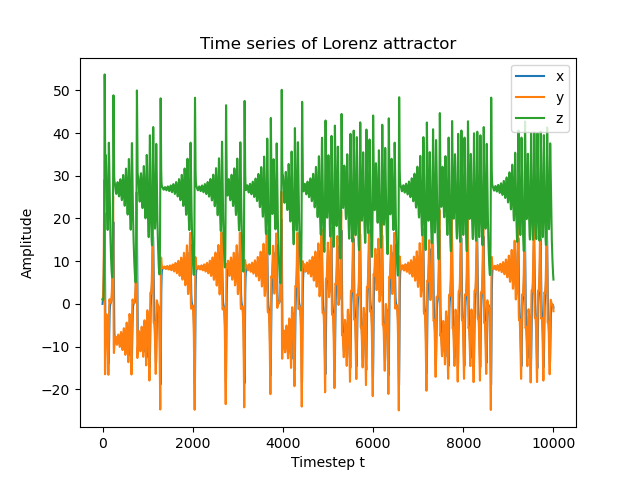

<IPython.core.display.Javascript object>


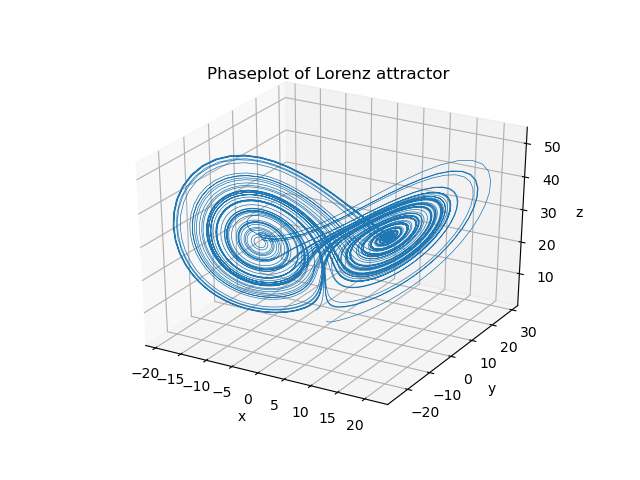

In [804]:
%matplotlib notebook
plt.plot(xs, label='x')
plt.plot(ys, label='y')
plt.plot(zs, label='z')

plt.title('Time series of Lorenz attractor')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Phaseplot of Lorenz attractor")

plt.show()

#### 2.3.2 Retrieving Drift and Diffusion coefficients

In [812]:
# hardcoding 2D diffusion coefficient for Lorenz attractor

nx, ny, nz = (100, 100, 100)
xd = np.zeros(nx)
yd = np.zeros(ny)
zd = np.zeros(nz)

xv, yv, zv = np.meshgrid(xd, yd, zd)

x_bins = xv # using bins, copying xv-grid
y_bins = xv
z_bins = xv

In [813]:
# Abtasten der Zeitserie
dx = np.max(xs) - np.min(xs) # "offset" x
dy = np.max(ys) - np.min(ys) # "offset" y
dz = np.max(zs) - np.min(zs) # "offset" z

tau = 1

transform = lambda x, d, b: int((x + (d/2)) * np.floor(b / d)) - 1

for i in range(len(xs[:-tau])):
    # 1. Transform x and y values of phase plot to meshgrid size
    xc = transform(xs[i], dx, nx)
    yc = transform(ys[i], dy, ny)
    zc = transform(zs[i], dz, nz)
    # 2. First calculate mean x change,then mean y change
    if (x_bins[xc][yc][zc] == 0):
        x_bins[xc][yc][zc] = xs[i + tau] - xs[i]
        y_bins[xc][yc][zc] = ys[i + tau] - ys[i]
        z_bins[xc][yc][zc] = zs[i + tau] - zs[i]
    else:
        x_bins[xc][yc][zc] = np.mean([x_bins[xc][yc][zc], xs[i + tau] - xs[i]]) # calculate mean change
        y_bins[xc][yc][zc] = np.mean([y_bins[xc][yc][zc], ys[i + tau] - ys[i]])
        z_bins[xc][yc][zc] = np.mean([z_bins[xc][yc][zc], zs[i + tau] - zs[i]])

<IPython.core.display.Javascript object>


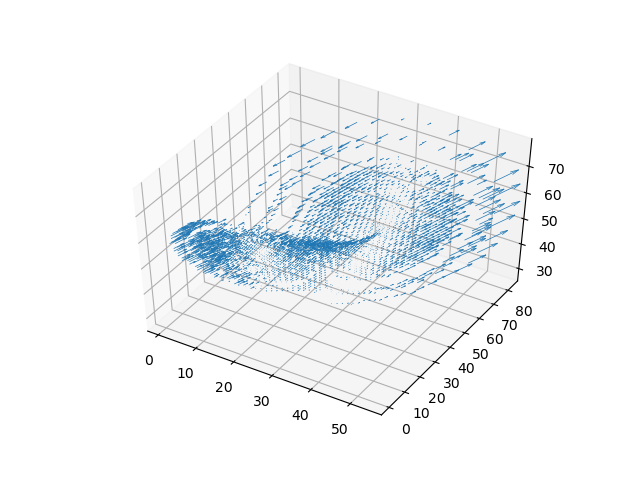

In [815]:
%matplotlib notebook

# standard axis
xd = np.arange(0, nx)
yd = np.arange(0, ny)
zd = np.arange(0, nz)

xv, yv, zv = np.meshgrid(xd, yd, zd)

# vector field
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.quiver(xv, yv, zv, x_bins, y_bins, z_bins, lw=0.5)

plt.show()

#### 2.3.3 Reconstructing time series

In [ ]:
dt = 0.1
T = 100
n = int(T / dt)
sqrtdt = np.sqrt(dt)

s = 10
r = 28
b = 2.667

g = [[4, 5, 3], 
     [5, 5, 6],
     [3, 6, 10]]

xs_ = []
ys_ = []
zs_ = []
xs_ = np.zeros(n)
ys_ = np.zeros(n)
zs_ = np.zeros(n)
xs_[0], ys_[0], zs_[0] = (0, 1, 1.05)

for i in range(n - 1):
    xs_[i + 1] = xs_[i] + D_1([xs], 0, [xs_[i]], tau=1, bins=15) * dt +\
        np.sum([g[0][i] * np.random.randn() for i in range(len(g[0]))]) * sqrtdt
    ys_[i + 1] = ys_[i] + D_1([ys], 0, [ys_[i]], tau=1, bins=15) * dt +\
        np.sum([g[1][i] * np.random.randn() for i in range(len(g[1]))]) * sqrtdt
    zs_[i + 1] = zs_[i] + D_1([zs], 0, [zs_[i]], tau=1, bins=15) * dt +\
        np.sum([g[2][i] * np.random.randn() for i in range(len(g[2]))]) * sqrtdt

In [ ]:
%matplotlib notebook
plt.plot(xs_, label='x')
plt.plot(ys_, label='y')
plt.plot(zs_, label='z')

plt.title('Reconstructed time series of Lorenz attractor')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020

[3] "The Fokker-Planck Equation" by H.Risken as of 1996